In [47]:
import tensorflow
from tensorflow import keras
from utils.classification import AlexNet, plot_history, load_train_data
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from utils.images import resample_img, normalize
from skimage.transform import resize
from random import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

### Task 5: Image classification: (20%)

This part contains 2 methods:

5.1 AlexNet Model: A deep learning based classifier

5.2 SVM Model: A machine learning based classifer

In [3]:
# Load data
img_40 = sitk.ReadImage('./data/common_40_image.nii.gz', sitk.sitkFloat32)
img_41 = sitk.ReadImage('./data/common_41_image.nii.gz', sitk.sitkFloat32)
img_42 = sitk.ReadImage('./data/common_42_image.nii.gz', sitk.sitkFloat32)
img_53 = sitk.ReadImage('./data/g1_53_image.nii.gz', sitk.sitkFloat32)
img_54 = sitk.ReadImage('./data/g1_54_image.nii.gz', sitk.sitkFloat32)
img_55 = sitk.ReadImage('./data/g1_55_image.nii.gz', sitk.sitkFloat32)

# img_40 = sitk.GetArrayFromImage(resample_img(normalize(img_40), out_size= [512,512,256]))
# img_41 = sitk.GetArrayFromImage(resample_img(normalize(img_41), out_size= [512,512,256]))
# img_42 = sitk.GetArrayFromImage(resample_img(normalize(img_42), out_size= [512,512,256]))

# img_53 = sitk.GetArrayFromImage(resample_img(normalize(img_53), out_size= [512,512,256]))
# img_54 = sitk.GetArrayFromImage(resample_img(normalize(img_54), out_size= [512,512,256]))
# img_55 = sitk.GetArrayFromImage(resample_img(normalize(img_55), out_size= [512,512,256]))

img_40 = sitk.GetArrayFromImage(resample_img(img_40, out_size= [512,512,256]))
img_41 = sitk.GetArrayFromImage(resample_img(img_41, out_size= [512,512,256]))
img_42 = sitk.GetArrayFromImage(resample_img(img_42, out_size= [512,512,256]))

img_53 = sitk.GetArrayFromImage(resample_img(img_53, out_size= [512,512,256]))
img_54 = sitk.GetArrayFromImage(resample_img(img_54, out_size= [512,512,256]))
img_55 = sitk.GetArrayFromImage(resample_img(img_55, out_size= [512,512,256]))

In [4]:
x_train, y_train = load_train_data([img_53, img_54, img_55])

#### Method 1: AlexNet: A deep learning model

In [36]:
def train_classifier(im_list, labels_list): 
    """
    Receive a list of images `im_list` and a list of vectors (one per image) 
    with the labels 0 or 1 depending on the sagittal 2D slice contains or not 
    the obturator foramen. Returns the trained classifier.
    """ 
    model = AlexNet(1,256,512,8,True,True)
    batch_size = 8

    # Class weight calculated for the inbalanced data
    class_weight = {0: 1.,
                    1: 6}
                    
    history = model.fit(im_list, labels_list, 
                        batch_size = batch_size,
                        class_weight = class_weight,
                        epochs = 10, verbose=1)
    return model

In [37]:
model = train_classifier(x_train, y_train)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 512, 8)       80        
                                                                 
 batch_normalization_10 (Bat  (None, 256, 512, 8)      32        
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 256, 512, 8)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 256, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 256, 16)      1168      
                                                                 
 batch_normalization_11 (Bat  (None, 128, 256, 16)    

/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/192 [==============================] - 88s 451ms/step - loss: 0.9535 - accuracy: 0.7734
Epoch 2/10
192/192 [==============================] - 90s 469ms/step - loss: 0.3734 - accuracy: 0.9212
Epoch 3/10
192/192 [==============================] - 93s 485ms/step - loss: 0.2397 - accuracy: 0.9512
Epoch 4/10
192/192 [==============================] - 85s 443ms/step - loss: 0.2019 - accuracy: 0.9648
Epoch 5/10
192/192 [==============================] - 75s 392ms/step - loss: 0.1421 - accuracy: 0.9701
Epoch 6/10
192/192 [==============================] - 75s 388ms/step - loss: 0.1195 - accuracy: 0.9772
Epoch 7/10
192/192 [==============================] - 75s 393ms/step - loss: 0.1017 - accuracy: 0.9798
Epoch 8/10
192/192 [==============================] - 76s 397ms/step - loss: 0.1207 - accuracy: 0.9779
Epoch 9/10
192/192 [==============================] - 75s 389ms/step - loss: 0.1118 - accuracy: 0.9831
Epoch 10/10
192/192 [==============================] - 76s 395ms/step - loss: 0.0929

In [54]:
def obturator_foramen_selection(im, classifier, id): 
    """
    Receive a CT image and the trained classifier. Returns the sagittal
    slice number with the maximum probability of containing the obturator
      foramen (can be on the left or right).
    """ 
    y_pred = classifier.predict(im)
    max_idx = np.where(y_pred == y_pred.max())[0][0]
    y_40 = np.zeros(512)
    y_40[161:199] = 1
    y_40[298:331] = 1

    y_41 = np.zeros(512)
    y_41[166:204] = 1
    y_41[289:320] = 1

    y_42 = np.zeros(512)
    y_42[162:204] = 1
    y_42[280:327] = 1

    if id == 40:
      y_label = y_40
    elif id == 41:
      y_label = y_41
    elif id == 42:
      y_label = y_42

    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(2,2,1)
    plt.plot(y_pred)
    plt.plot(y_label)
    plt.title("max probability of common {0} = {1}".format(id, y_pred.max()))

    ax2 = plt.subplot(2,2,2)
    plt.imshow(im[np.where(y_pred == y_pred.max())[0][0]], cmap = "Greys_r")
    plt.title("The slice of highest probability is {}".format(max_idx))
    
    

In [39]:
def load_test_data(img):
    x_val = []
    for idx in range(512):
        slice = img[:,:,idx]
        x_val.append(slice)
    x_val = np.array(x_val)
    return x_val

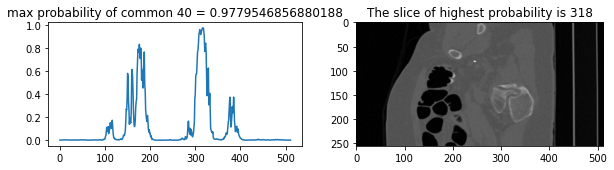

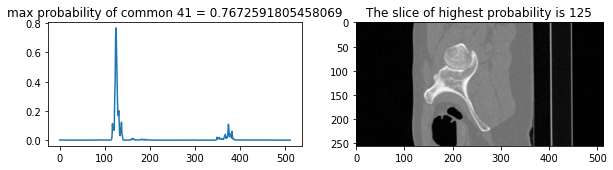

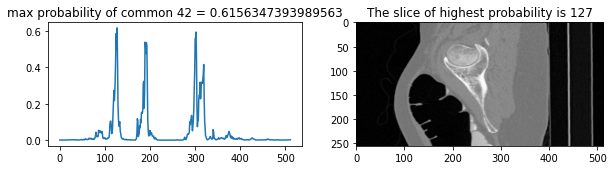

In [40]:
imgs_test = [img_40, img_41, img_42]
id = [40, 41, 42]
for idx in range(len(id)):
    im = load_test_data(imgs_test[idx])
    obturator_foramen_selection(im, model, id[idx])

##### Trained model: By testing the parameters in training, the best model is saved.

In [48]:
best_model = tensorflow.keras.models.load_model('best_Alex_model')

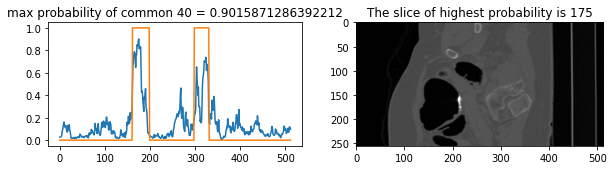

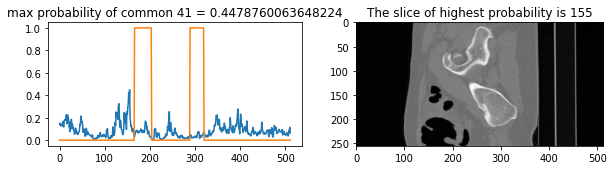

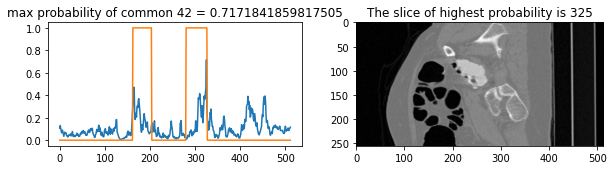

In [63]:
imgs_test = [img_40, img_41, img_42]
id = [40, 41, 42]
for idx in range(len(id)):
    im = load_test_data(imgs_test[idx])
    obturator_foramen_selection(im, best_model, id[idx])

#### Methods 2: SVM: A machine learning based model

However, the results are all zeros in the prediction, which is not right.

In [50]:
def train_classifier_svm(im_list, labels_list): 
    """
    Receive a list of images `im_list` and a list of vectors (one per image) 
    with the labels 0 or 1 depending on the sagittal 2D slice contains or not 
    the obturator foramen. Returns the trained classifier.
    """ 
    
    # Class weight calculated for the inbalanced data
    class_weight = {0: 1.,
                    1: 6}

    model = svm.SVC(probability=True,kernel='rbf',class_weight= class_weight, random_state=1536)
    model.fit(im_list, labels_list)
    return model

In [60]:
def obturator_foramen_selection_svm(im, classifier, id): 
    """
    Receive a CT image and the trained classifier. Returns the sagittal
    slice number with the maximum probability of containing the obturator
      foramen (can be on the left or right).
    """ 
    im_re = im.reshape((im.shape[0], im.shape[1] * im.shape[2]))
    y_pred = classifier.predict(im_re)
    max_idx = np.where(y_pred == y_pred.max())[0][0]
    y_40 = np.zeros(512)
    y_40[161:199] = 1
    y_40[298:331] = 1

    y_41 = np.zeros(512)
    y_41[166:204] = 1
    y_41[289:320] = 1

    y_42 = np.zeros(512)
    y_42[162:204] = 1
    y_42[280:327] = 1

    if id == 40:
      y_label = y_40
    elif id == 41:
      y_label = y_41
    elif id == 42:
      y_label = y_42

    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(2,2,1)
    plt.plot(y_pred)
    plt.plot(y_label)
    plt.title("max probability of common {0} = {1}".format(id, y_pred.max()))

    ax2 = plt.subplot(2,2,2)
    plt.imshow(im[np.where(y_pred == y_pred.max())[0][0]], cmap = "Greys_r")
    plt.title("The slice of highest probability is {}".format(max_idx))
    
    

In [53]:
X = x_train.reshape((x_train.shape[0],x_train.shape[1] * x_train.shape[2] ))
svm_model = train_classifier_svm(X, y_train)

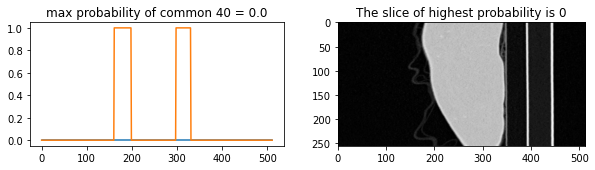

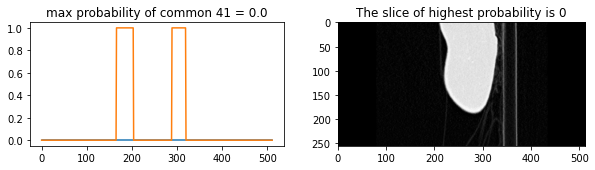

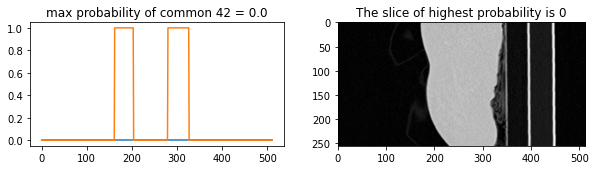

In [62]:
imgs_test = [img_40, img_41, img_42]
id = [40, 41, 42]
for idx in range(len(id)):
    im = load_test_data(imgs_test[idx])
    obturator_foramen_selection_svm(im, svm_model, id[idx])